# Reading May and Beg. of June Data

In [1]:
%matplotlib inline
#from matplotlib import pyplot as pt
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
import pandas as pd
import seaborn as sns

import numpy as np

from datetime import datetime, timedelta

import os
import glob

TIME_INTERVAL = '4H'

/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def load_local_data():
    csv_path = os.path.join(os.getcwd(), 'data-gala/*.txt')
    all_files = glob.glob(csv_path)
    
    all_files = ['/home/lucia/lucia/metis/01-benson/data-gala/01_turnstile_150502.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/02_turnstile_150509.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/03_turnstile_150516.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/04_turnstile_150523.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/05_turnstile_150530.txt',
                 '/home/lucia/lucia/metis/01-benson/data-gala/06_turnstile_150606.txt']
    
  #  print 'reading data from files:'
  #  for f in all_files:
  #      print f
    
    data = pd.concat((pd.read_csv(f) for f in all_files))
    
    # strip whitespace off column headers (eg 'EXITS               ' has trailing spaces)
    data = data.rename(columns=lambda x: x.strip())
    return data

data = load_local_data()
print "\ngot %i rows total." % len(data)
#data.head()


got 1152582 rows total.


# How many unique stations do we have in our set?

In [3]:
# How many stations are there?
unique_stations = data.STATION.unique()
print len(unique_stations)

384


# Transforming data: creating datetime, entries and exits diffs, and sums

In [4]:
# make a datetime column
data['DATETIME'] = pd.to_datetime(data.DATE + ' ' + data.TIME, format="%m/%d/%Y %H:%M:%S")
data.head()
data.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
191727,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,05:00:00,REGULAR,5554,212,2015-06-05 05:00:00
191728,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,09:00:00,REGULAR,5554,212,2015-06-05 09:00:00
191729,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,13:00:00,REGULAR,5554,212,2015-06-05 13:00:00
191730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,17:00:00,REGULAR,5554,212,2015-06-05 17:00:00
191731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,21:00:00,REGULAR,5554,212,2015-06-05 21:00:00


In [5]:
# make a datetime column
data['DATETIME'] = pd.to_datetime(data.DATE + ' ' + data.TIME, format="%m/%d/%Y %H:%M:%S")
data.head()
data.tail()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
191727,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,05:00:00,REGULAR,5554,212,2015-06-05 05:00:00
191728,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,09:00:00,REGULAR,5554,212,2015-06-05 09:00:00
191729,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,13:00:00,REGULAR,5554,212,2015-06-05 13:00:00
191730,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,17:00:00,REGULAR,5554,212,2015-06-05 17:00:00
191731,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,06/05/2015,21:00:00,REGULAR,5554,212,2015-06-05 21:00:00


In [6]:
# Calclate new columns ENTRIES_DIFF and EXITS_DIFF for each unique turnstile/device.
# The first entry is NaN, the rest of the entries are the difference from the previous.
turnstile_groupby = data.groupby(['C/A','UNIT','SCP','STATION'])
for diff_field in ('ENTRIES','EXITS'):
    data[diff_field + '_DIFF'] = turnstile_groupby[diff_field].transform(pd.Series.diff)
data.head(3)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,ENTRIES_DIFF,EXITS_DIFF
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,00:00:00,REGULAR,5106770,1729635,2015-04-25 00:00:00,NaN,NaN
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,04:00:00,REGULAR,5106810,1729649,2015-04-25 04:00:00,40.0,14.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,04/25/2015,08:00:00,REGULAR,5106835,1729680,2015-04-25 08:00:00,25.0,31.0


In [7]:
# sanity check for getting the differences:
nan_entries = len(data[data.ENTRIES_DIFF.isnull()])
total_unique_turnstiles = len(turnstile_groupby)
print 'the number of NaN entries should equal the total unique turnstiles.'
print nan_entries, total_unique_turnstiles

assert nan_entries == total_unique_turnstiles

the number of NaN entries should equal the total unique turnstiles.
4568 4568


In [8]:
# learning how to deal with NA values
print len(data[data.ENTRIES_DIFF.isnull()])
print len(data.dropna())
print len(data)

4568
1148014
1152582


In [9]:
# prepisovanie dat
#data.ix[ data.TIME > '20:00:00','DATETIME'] = data.DATETIME'20:00:00' 
#data['APPROXTIME'] = data['DATETIME'].apply(lambda dt: datetime(dt.year, dt.month, dt.day,4*(dt.hour//4)))
#filt = data[ data.TIME == '07:00:00']
#print filt.head()

In [10]:
# dropping NA values and all non-REGULAR recordings
# calculating percentage of "regular" values vs. all nonNA values
reg_data = data.dropna()
reg_data = reg_data[ reg_data['DESC'] == 'REGULAR']
print len(reg_data)/float(len(data.dropna()))
#print reg_data.describe()

0.996898121451


In [11]:
#rng = pd.date_range('1/1/2011', periods=5, freq='H')
#ts = pd.Series(np.random.randn(len(rng)), index=rng)
#print ts
#print ts.resample('2H').sum().head()

In [12]:
# FYI: there are about 48% of rows that are recorded at times other than 0,4,8,12,16 or 20 hours !!! 
#times_4h = ['00:00:00','04:00:00','08:00:00','12:00:00','16:00:00','20:00:00']
#filtered_times = reg_data[ reg_data['APPROXTIME'].isin(times_4h)]
#print filtered_times['TIME'].unique()
#print reg_data['TIME'].unique()
#print (len(reg_data)-len(filtered_times))/float(len(reg_data))
#
#print reg_data['APPROXTIME'].describe()
#check for 4-h outsiders: none! :) 
#data['APPROXTIME'].apply(lambda dt: dt.hour).unique()

# Dealing with 4-h timestamps

In [13]:
#print reg_data.head()
# group by station name and datetime,
station_time_groupby = reg_data.groupby(['STATION','DATETIME','DATE','TIME'], as_index=False)
station_period_totals = station_time_groupby[['ENTRIES_DIFF', 'EXITS_DIFF']].sum()
rounded_times = station_period_totals.set_index('DATETIME').groupby('STATION')
rounded_times = rounded_times.resample(TIME_INTERVAL,convention='end').sum()
print len(station_period_totals), len(rounded_times)
station_of_interest = '1 AVE'
print station_of_interest
print 'len before rounding:'
print len(station_period_totals[station_period_totals.STATION == station_of_interest])
print 'len after rounding:'
print len(rounded_times.loc[station_of_interest])
rounded_times = rounded_times.reset_index()
print rounded_times.head()

168235 95848
1 AVE
len before rounding:
257
len after rounding:
251
  STATION            DATETIME  ENTRIES_DIFF  EXITS_DIFF
0   1 AVE 2015-04-25 04:00:00           3.0        76.0
1   1 AVE 2015-04-25 08:00:00           2.0        53.0
2   1 AVE 2015-04-25 12:00:00           2.0        54.0
3   1 AVE 2015-04-25 16:00:00           4.0        57.0
4   1 AVE 2015-04-25 20:00:00           0.0        41.0


# Finding Max Entries Stations

In [14]:
top_20_entries = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
top_20_entries = top_20_entries.groupby(['STATION'])
top_20_entries = top_20_entries['ENTRIES_DIFF','EXITS_DIFF'].sum().sort_values(by='ENTRIES_DIFF', ascending=0)
top_20_entries = top_20_entries[:20]
print top_20_entries

                 ENTRIES_DIFF  EXITS_DIFF
STATION                                  
34 ST-PENN STA      6388309.0   5517451.0
42 ST-GRD CNTRL     5421175.0   5054367.0
34 ST-HERALD SQ     4359345.0   4116555.0
86 ST               4303861.0   3391643.0
14 ST-UNION SQ      4133901.0   3696293.0
42 ST-TIMES SQ      3709823.0   3391320.0
42 ST-PA BUS TE     3145886.0   2819216.0
96 ST               3028903.0   2016287.0
59 ST-COLUMBUS      2802928.0   2260833.0
FULTON ST           2750483.0   2370208.0
CANAL ST            2704407.0   2134621.0
125 ST              2672914.0   2490402.0
CHAMBERS ST         2603996.0   1590609.0
23 ST               2470256.0   1898957.0
59 ST               2410684.0   1992695.0
MAIN ST             2267407.0   1887297.0
47-50 ST-ROCK       2102758.0   2174243.0
72 ST               2017840.0   1489414.0
ROOSEVELT AVE       1922060.0   1515332.0
50 ST               1893964.0   1573214.0


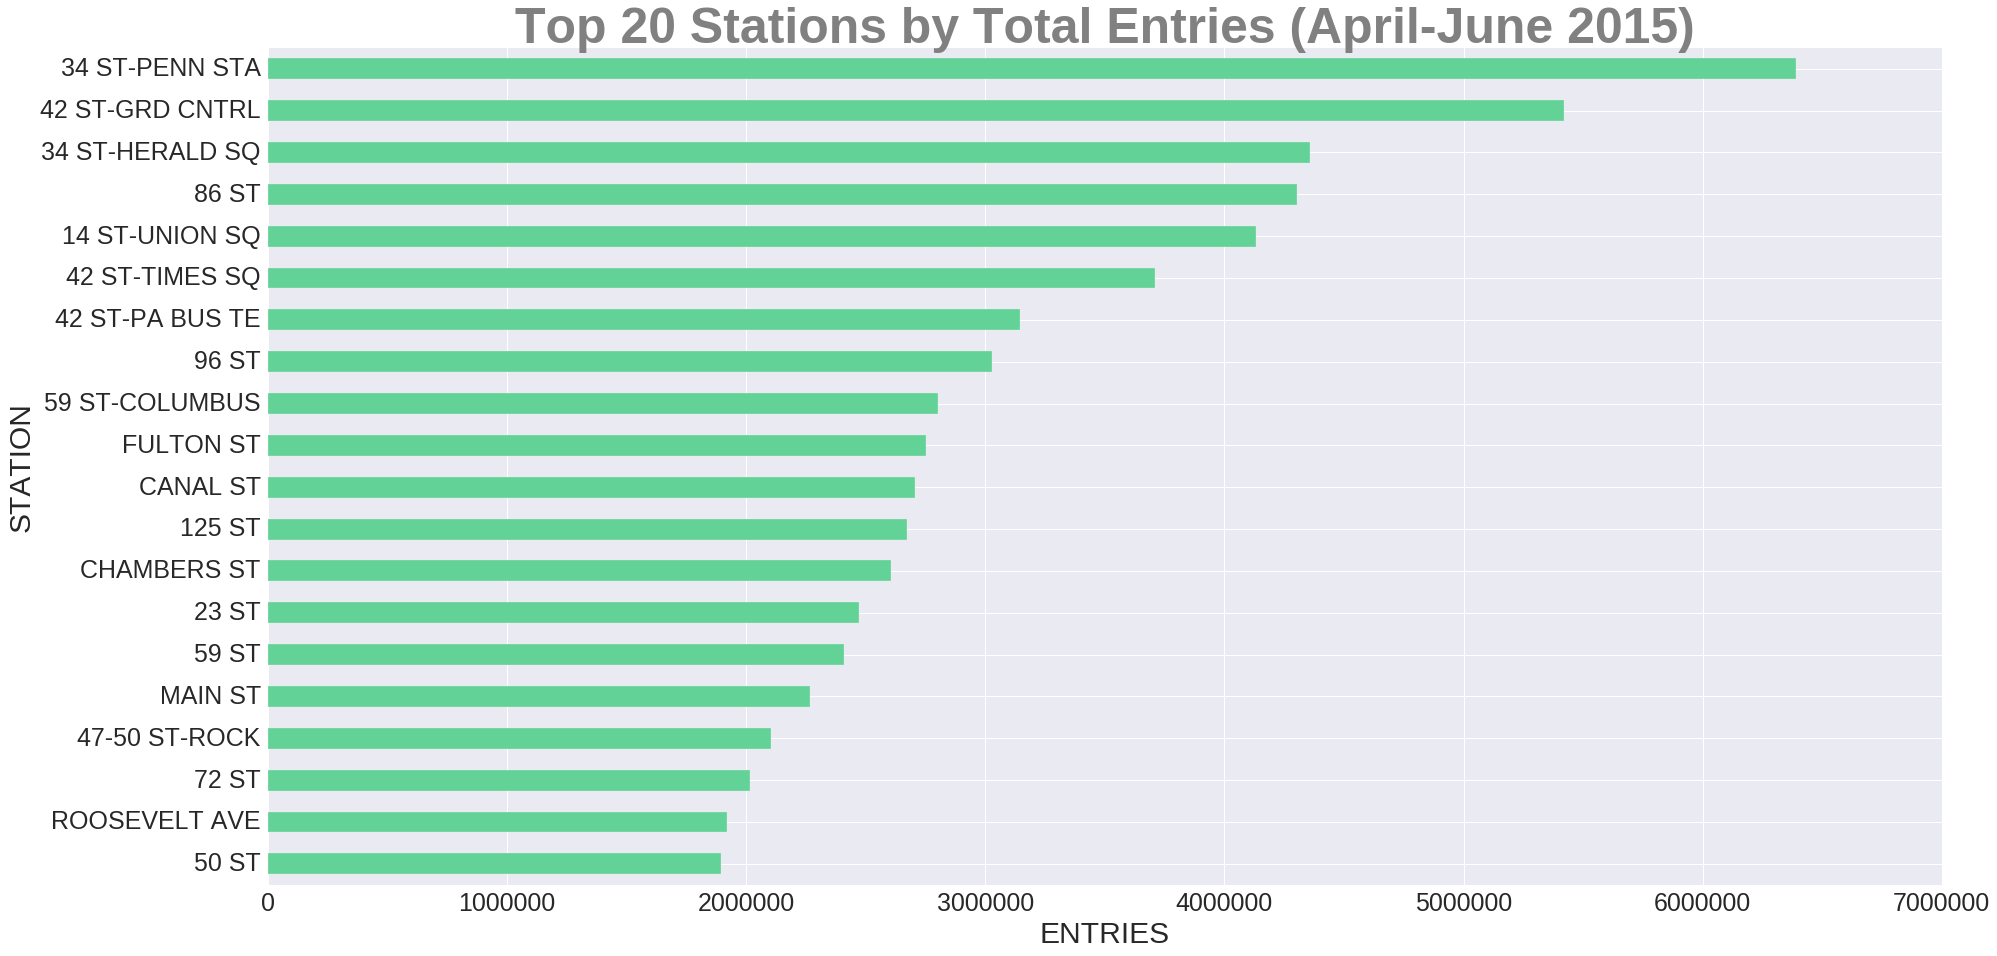

In [15]:
top_20_entries_vals = top_20_entries.ENTRIES_DIFF
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.figure(figsize = (30,15))
plt.title('Top 20 Stations by Total Entries (April-June 2015)',fontsize=50, color='grey', fontweight='bold')
plt.xlabel('ENTRIES',fontsize=30)
plt.ylabel('Station',fontsize=30)
#fig, ax = plt.subplots(figsize=[25,10])
top_20_entries_vals.sort_values(ascending=True).plot(kind='barh', color ='#63d297')
path = "entries/top_20_entries_stations.png"
plt.savefig(path)

# Station Entries Day Time Heatmap

In [16]:
data_dt_entries = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
data_dt_entries = data_dt_entries[['STATION', 'DATETIME', 'ENTRIES_DIFF']]
#print data_dt_entries.describe()

In [17]:
data_dt_entries['DAY'] = data_dt_entries['DATETIME'].dt.dayofweek
data_dt_entries['TIME'] = data_dt_entries['DATETIME'].dt.time
data_dt_entries.head()

,STATION,DATETIME,ENTRIES_DIFF,DAY,TIME
0,1 AVE,2015-04-25 04:00:00,3.0,5,04:00:00
1,1 AVE,2015-04-25 08:00:00,2.0,5,08:00:00
2,1 AVE,2015-04-25 12:00:00,2.0,5,12:00:00
3,1 AVE,2015-04-25 16:00:00,4.0,5,16:00:00
4,1 AVE,2015-04-25 20:00:00,0.0,5,20:00:00


In [18]:
stations_dt_entries = data_dt_entries.groupby(['STATION','DAY','TIME'])
stations_dt_entries = stations_dt_entries['ENTRIES_DIFF'].mean()
stations_dt_entries.head(7)

STATION  DAY  TIME    
1 AVE    0    00:00:00     846.000000
              04:00:00     381.666667
              08:00:00    1450.333333
              12:00:00    4828.000000
              16:00:00    4641.666667
              20:00:00    6295.000000
         1    00:00:00    3126.666667
Name: ENTRIES_DIFF, dtype: float64

## Top 100 Stations

In [19]:
top_100_entries = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
top_100_entries = top_100_entries.groupby(['STATION'])
top_100_entries = top_100_entries['ENTRIES_DIFF','EXITS_DIFF'].sum().sort_values(by='ENTRIES_DIFF', ascending=0)
top_100_entries = top_100_entries[:100].reset_index()
stations_entries = top_100_entries['STATION']
#print stations_entries

34 ST-PENN STA
42 ST-GRD CNTRL
34 ST-HERALD SQ
86 ST
14 ST-UNION SQ
42 ST-TIMES SQ
42 ST-PA BUS TE
96 ST
59 ST-COLUMBUS
FULTON ST
CANAL ST
125 ST
CHAMBERS ST
23 ST
59 ST
MAIN ST
47-50 ST-ROCK
72 ST
ROOSEVELT AVE
50 ST


/home/lucia/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


W 4 ST-WASH SQ
WALL ST
BARCLAYS CENTER
PATH WTC
JAY ST-METROTEC
14 ST
JAMAICA CENTER
77 ST
145 ST
149 ST-GR CONC
8 AVE
CHURCH AVE
42 ST-BRYANT PK
LEXINGTON-53 ST
BOROUGH HALL/CT
116 ST
28 ST
GRAND ST
JOURNAL SQUARE
68ST-HUNTER COL
MYRTLE AVE
BOWLING GREEN
SUTPHIN BLVD
9TH STREET
33 ST
JFK JAMAICA CT1
DEKALB AVE
CROWN HTS-UTICA
FOREST HILLS-71
KINGS HIGHWAY
103 ST
WOODHAVEN BLVD
161 ST-YANKEE
UNION TPK-KEW G
LEXINGTON AVE
23 ST-5 AVE
168 ST-BROADWAY
BROADWAY/LAFAY
FORDHAM ROAD
66 ST-LINCOLN
49 ST-7 AVE
5 AVE-53 ST
181 ST
79 ST
SPRING ST
23 ST-6 AVE
NOSTRAND AVE
THIRTY THIRD ST
HARRISON
JUNCTION BLVD
135 ST
JAMAICA-179 ST
BEDFORD AVE
103 ST-CORONA
167 ST
149 ST-3 AVE
1 AVE
5 AVE-59 ST
14 ST-6 AVE
2 AVE
8 ST-B'WAY NYU
KINGSBRIDGE RD
51 ST
STILLWELL AVE
PAVONIA/NEWPORT
BROOKLYN BRIDGE
36 ST
DITMARS BL-31 S
DELANCEY ST
90 ST-ELMHURST
61 ST/WOODSIDE
FT HAMILTON PKY
FLATBUSH AVE
ASTOR PLACE
PRINCE ST-B'WAY
RECTOR ST
170 ST
7 AVE-53 ST
63 DR-REGO PARK
E 177 ST-PARKCH


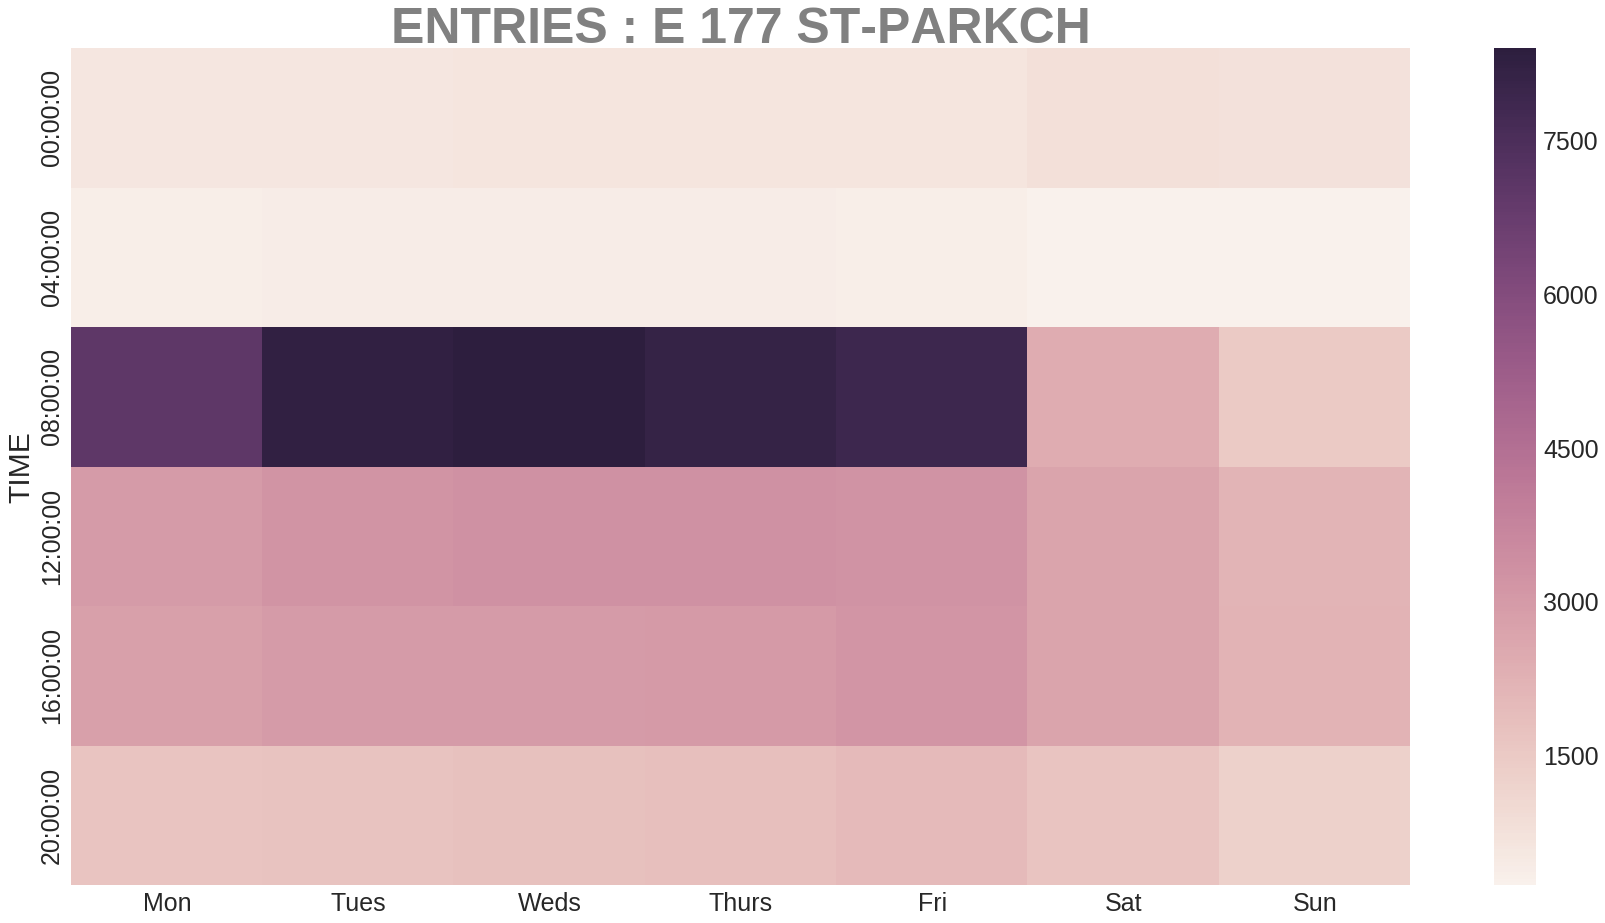

In [20]:
#station = '1 AVE' 14 ST-UNION SQ
#station = '34 ST-PENN STA'
#for station in ['34 ST-PENN STA']:
for station in stations_entries:
    print station
    one_station = data_dt_entries[ data_dt_entries['STATION'] == station ]
    #print one_station.head()
    #print one_station.describe()
    one_groupby = one_station.groupby(['DAY','TIME'])
    one_dt = one_groupby['ENTRIES_DIFF'].mean().reset_index()
    #print one_dt.describe()
    # changing format of the pandas data frame from three-columns to 2-column indices and third-column as values
    # of a matrix
    one_dt_heatmap = one_dt.set_index(['DAY', 'TIME']).ENTRIES_DIFF.unstack(0)
    days_mapper = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    one_dt_heatmap.columns = [days_mapper[c] for c in one_dt_heatmap.columns]
    plt.clf()
    matplotlib.rc('xtick', labelsize=25) 
    matplotlib.rc('ytick', labelsize=25) 
    plt.figure(figsize = (30,15))
    plt.title('ENTRIES : ' + station, fontsize=50, color='grey', fontweight='bold')
    plt.xlabel('DAY',fontsize=30)
    plt.ylabel('TIME',fontsize=30)
    #x = range(0,7,1)
    #xLabel = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    #plt.xticks(x,xLabel)
    #fig, ax = plt.subplots(figsize=[25,10])
    sns.heatmap(one_dt_heatmap)
    stationpath = station
    stationdict = {'BOROUGH HALL/CT': 'BOROUGH HALL-CT',
                   'HOYT/SCHERMER' : 'HOYT-SCHERMER', 
                   'BEDFORD/NOSTRAN' : 'BEDFORD-NOSTRAN',
                   'VERNON/JACKSON': 'VERNON-JACKSON',
                   '33 ST/RAWSON ST': '33 ST-RAWSON ST',
                   'BROADWAY/LAFAY' : 'BROADWAY-LAFAY',
                   'PAVONIA/NEWPORT' : 'PAVONIA-NEWPORT',
                   '61 ST/WOODSIDE' : '61 ST-WOODSIDE'}
    if station in stationdict:
        stationpath = stationdict[station]
    path = "entries/heatmap_" + stationpath + ".png"
    plt.savefig(path)

# Finding Max Exits Stations

In [21]:
top_20_exits = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
top_20_exits = top_20_exits.groupby(['STATION'])
top_20_exits = top_20_exits['ENTRIES_DIFF','EXITS_DIFF'].sum().sort_values(by='EXITS_DIFF', ascending=0)
top_20_exits = top_20_exits[:20]
print top_20_exits

                 ENTRIES_DIFF  EXITS_DIFF
STATION                                  
34 ST-PENN STA      6388309.0   5517451.0
42 ST-GRD CNTRL     5421175.0   5054367.0
34 ST-HERALD SQ     4359345.0   4116555.0
14 ST-UNION SQ      4133901.0   3696293.0
86 ST               4303861.0   3391643.0
42 ST-TIMES SQ      3709823.0   3391320.0
42 ST-PA BUS TE     3145886.0   2819216.0
125 ST              2672914.0   2490402.0
FULTON ST           2750483.0   2370208.0
59 ST-COLUMBUS      2802928.0   2260833.0
47-50 ST-ROCK       2102758.0   2174243.0
CANAL ST            2704407.0   2134621.0
96 ST               3028903.0   2016287.0
59 ST               2410684.0   1992695.0
23 ST               2470256.0   1898957.0
MAIN ST             2267407.0   1887297.0
PATH WTC            1627036.0   1700561.0
LEXINGTON-53 ST     1441833.0   1657666.0
W 4 ST-WASH SQ      1721922.0   1655868.0
CHAMBERS ST         2603996.0   1590609.0


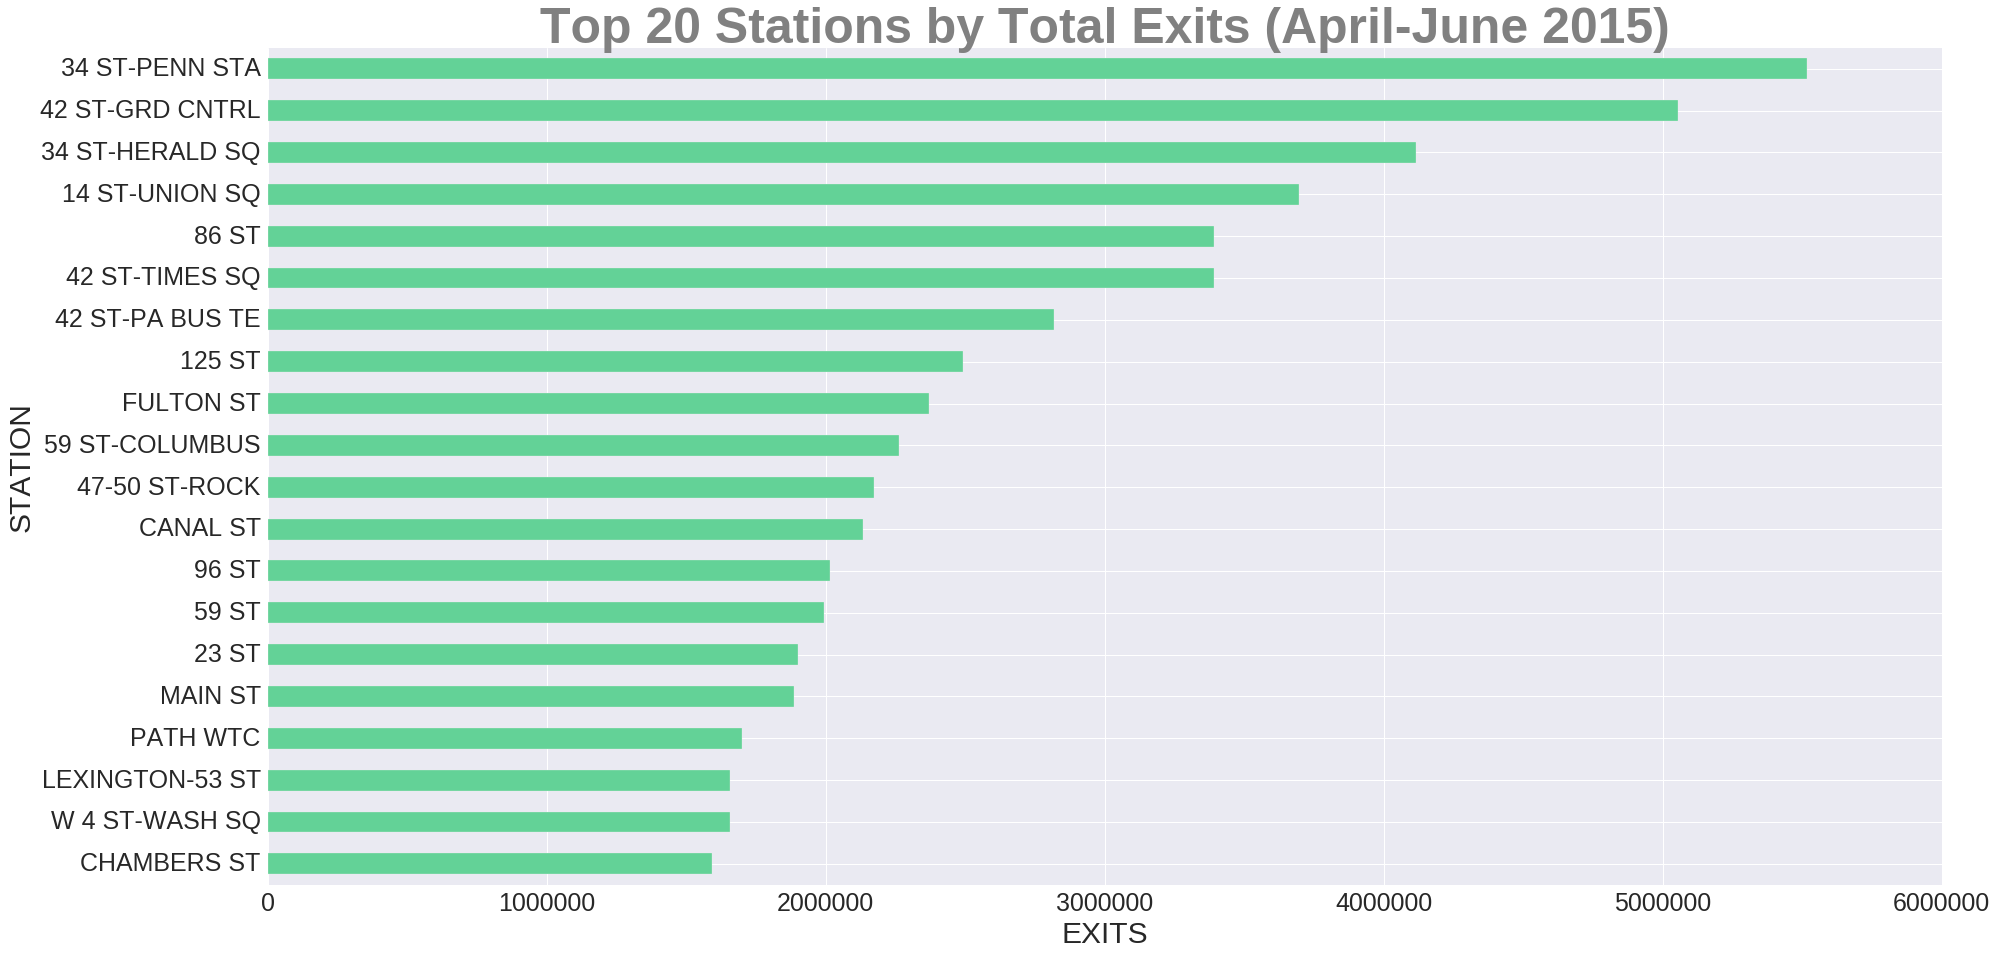

In [22]:
top_20_exits_vals = top_20_exits.EXITS_DIFF
matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 
plt.figure(figsize = (30,15))
plt.title('Top 20 Stations by Total Exits (April-June 2015)',fontsize=50, color='grey', fontweight='bold')
plt.xlabel('EXITS',fontsize=30)
plt.ylabel('Station',fontsize=30)
#fig, ax = plt.subplots(figsize=[25,10])
top_20_exits_vals.sort_values(ascending=True).plot(kind='barh', color ='#63d297')
path = "exits/top_20_exits_stations.png"
plt.savefig(path)

# Station Exits Day Time Heatmap

In [23]:
data_dt_exits = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
data_dt_exits = data_dt_exits[['STATION', 'DATETIME', 'EXITS_DIFF']]
#print data_dt_entries.describe()

In [24]:
data_dt_exits['DAY'] = data_dt_exits['DATETIME'].dt.dayofweek
data_dt_exits['TIME'] = data_dt_exits['DATETIME'].dt.time
data_dt_exits.head()

,STATION,DATETIME,EXITS_DIFF,DAY,TIME
0,1 AVE,2015-04-25 04:00:00,76.0,5,04:00:00
1,1 AVE,2015-04-25 08:00:00,53.0,5,08:00:00
2,1 AVE,2015-04-25 12:00:00,54.0,5,12:00:00
3,1 AVE,2015-04-25 16:00:00,57.0,5,16:00:00
4,1 AVE,2015-04-25 20:00:00,41.0,5,20:00:00


In [25]:
stations_dt_exits = data_dt_exits.groupby(['STATION','DAY','TIME'])
stations_dt_exits = stations_dt_exits['EXITS_DIFF'].mean()
stations_dt_exits.head(7)

STATION  DAY  TIME    
1 AVE    0    00:00:00     976.833333
              04:00:00     399.666667
              08:00:00    2681.000000
              12:00:00    5285.166667
              16:00:00    4036.500000
              20:00:00    6307.333333
         1    00:00:00    3323.666667
Name: EXITS_DIFF, dtype: float64

# Top 100 Stations

In [26]:
top_100_exits = rounded_times[ (rounded_times['ENTRIES_DIFF'] >= 0) & (rounded_times['ENTRIES_DIFF'] < 1000000)]
top_100_exits = top_100_exits.groupby(['STATION'])
top_100_exits = top_100_exits['ENTRIES_DIFF','EXITS_DIFF'].sum().sort_values(by='EXITS_DIFF', ascending=0)
top_100_exits = top_100_exits[:100].reset_index()
stations_exits = top_100_exits['STATION']
#print stations_exits

34 ST-PENN STA
42 ST-GRD CNTRL
34 ST-HERALD SQ
14 ST-UNION SQ
86 ST
42 ST-TIMES SQ
42 ST-PA BUS TE
125 ST
FULTON ST
59 ST-COLUMBUS
47-50 ST-ROCK
CANAL ST
96 ST
59 ST
23 ST
MAIN ST
PATH WTC
LEXINGTON-53 ST
W 4 ST-WASH SQ
CHAMBERS ST
50 ST
BARCLAYS CENTER
ROOSEVELT AVE
72 ST
WALL ST
42 ST-BRYANT PK
77 ST
JAMAICA CENTER
9TH STREET
145 ST
14 ST
BROADWAY/LAFAY
28 ST
8 AVE
BOWLING GREEN
CHURCH AVE
UNION TPK-KEW G
5 AVE-53 ST
BEDFORD AVE
JFK JAMAICA CT1
BOROUGH HALL/CT
KINGS HIGHWAY
JAY ST-METROTEC
23 ST-6 AVE
GRAND ST
33 ST
SUTPHIN BLVD
181 ST
103 ST
66 ST-LINCOLN
14 ST-6 AVE
68ST-HUNTER COL
MYRTLE AVE
CROWN HTS-UTICA
1 AVE
49 ST-7 AVE
JUNCTION BLVD
116 ST
THIRTY THIRD ST
BROOKLYN BRIDGE
51 ST
7 AVE-53 ST
82 ST-JACKSON H
PAVONIA/NEWPORT
168 ST-BROADWAY
61 ST/WOODSIDE
ASTOR PLACE
LEXINGTON AVE
2 AVE
NOSTRAND AVE
GROVE STREET
E 177 ST-PARKCH
PRINCE ST-B'WAY
WOODHAVEN BLVD
103 ST-CORONA
JOURNAL SQUARE
CITY / BUS
DITMARS BL-31 S
STILLWELL AVE
SPRING ST
161 ST-YANKEE
NEWARK HM HE
SOUTH FERRY
167 

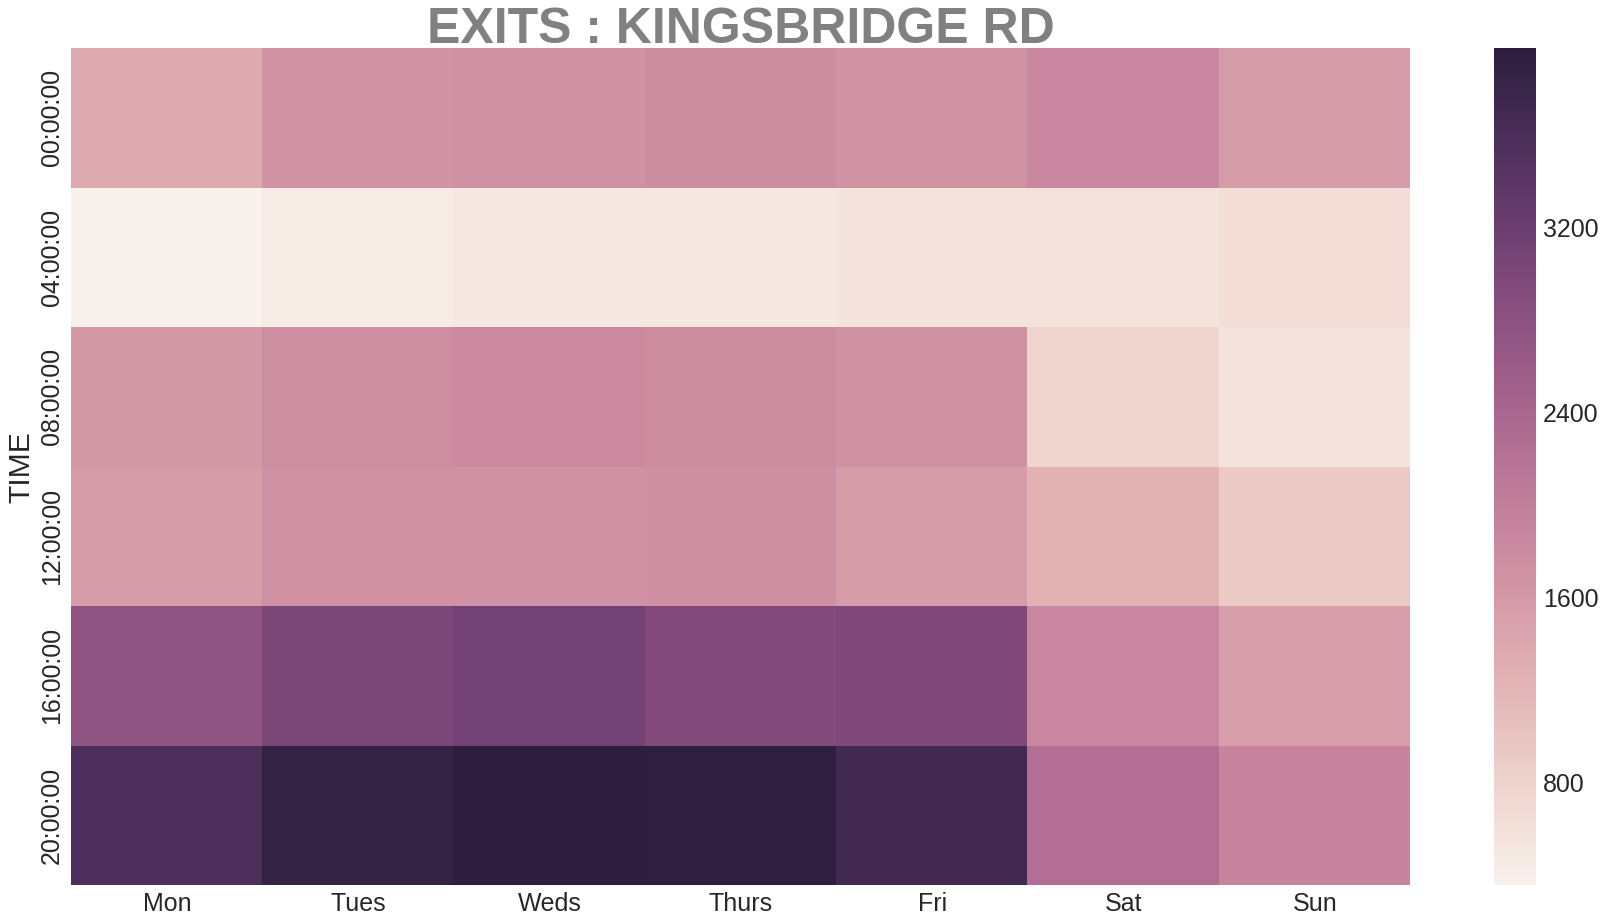

In [27]:
#station = '1 AVE' 14 ST-UNION SQ
#station = '34 ST-PENN STA'
#for station in ['34 ST-PENN STA']:
for station in stations_exits:
    print station
    one_station = data_dt_exits[ data_dt_exits['STATION'] == station ]
    #print one_station.head()
    #print one_station.describe()
    one_groupby = one_station.groupby(['DAY','TIME'])
    one_dt = one_groupby['EXITS_DIFF'].mean().reset_index()
    #print one_dt.describe()
    # changing format of the pandas data frame from three-columns to 2-column indices and third-column as values
    # of a matrix
    one_dt_heatmap = one_dt.set_index(['DAY', 'TIME']).EXITS_DIFF.unstack(0)
    days_mapper = {0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'}
    one_dt_heatmap.columns = [days_mapper[c] for c in one_dt_heatmap.columns]
    plt.clf()
    matplotlib.rc('xtick', labelsize=25) 
    matplotlib.rc('ytick', labelsize=25) 
    plt.figure(figsize = (30,15))
    plt.title("EXITS : " +station, fontsize=50, color='grey', fontweight='bold')
    plt.xlabel('DAY',fontsize=30)
    plt.ylabel('TIME',fontsize=30)
    #x = range(0,7,1)
    #xLabel = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    #plt.xticks(x,xLabel)
    #fig, ax = plt.subplots(figsize=[25,10])
    sns.heatmap(one_dt_heatmap)
    stationpath = station
    stationdict = {'BOROUGH HALL/CT': 'BOROUGH HALL-CT',
                   'HOYT/SCHERMER' : 'HOYT-SCHERMER', 
                   'BEDFORD/NOSTRAN' : 'BEDFORD-NOSTRAN',
                   'VERNON/JACKSON': 'VERNON-JACKSON',
                   '33 ST/RAWSON ST': '33 ST-RAWSON ST',
                   'BROADWAY/LAFAY' : 'BROADWAY-LAFAY',
                   'PAVONIA/NEWPORT' : 'PAVONIA-NEWPORT',
                   '61 ST/WOODSIDE' : '61 ST-WOODSIDE',
                   'CITY / BUS' : 'CITY - BUS'}
    if station in stationdict:
        stationpath = stationdict[station]
    path = "exits/heatmap_" + stationpath + ".png"
    plt.savefig(path)

# Group by station and datetime

In [28]:
# group by station name and datetime,
station_time_groupby = reg_data.groupby(['STATION','DATETIME'])

# data.join(station_time_groupby['ENTRIES_DIFF','EXITS_DIFF'].sum(), on=['STATION','DATETIME'], rsuffix='_r')
station_time_groupby['ENTRIES_DIFF','EXITS_DIFF'].sum().head()

ENTRIES_DIFF  EXITS_DIFF
STATION DATETIME                                     
1 AVE   2015-04-25 04:00:00           3.0        76.0
        2015-04-25 08:00:00           2.0        53.0
        2015-04-25 12:00:00           2.0        54.0
        2015-04-25 16:00:00           4.0        57.0
        2015-04-25 20:00:00           0.0        41.0

In [29]:
# The dataset also leads to many negative diff values and unreasonably high negative diff peaks (-1.4x10^9)
data[data.ENTRIES_DIFF < 0].min()

C/A                            A011
UNIT                           R007
SCP                        00-00-00
STATION                       1 AVE
LINENAME                          1
DIVISION                        BMT
DATE                     04/25/2015
TIME                       00:00:00
DESC                     RECOVR AUD
ENTRIES                           0
EXITS                             0
DATETIME        2015-04-25 04:00:00
ENTRIES_DIFF           -1.40381e+09
EXITS_DIFF             -1.11135e+07
dtype: object